### Imports and path

In [1]:
# lib
import sys

sys.path.append("..")

# set cwd one up
import os

os.chdir("..")
path = "data/hes/Hes1_example.csv"

os.getcwd()

'/Users/tsd/Python/GPCell'

In [2]:
from gpcell import utils, plots
import numpy as np

### Setting up params

In [3]:
par1 = np.array([300, 1, 0.07, 0.07, 1, 1, 0], dtype=np.float64)
par2 = np.array([100, 3, 0.03, 0.03, 1, 1, 18], dtype=np.float64)
n_cells = 200  # total replicates used in the simulation
t_final_vals = [1500, 600]  # 25/10 hours
noise_vals = [np.sqrt(x) for x in [0.1, 0.5]]

sim_params = [[noise, t_final_vals[0], n_cells] for noise in noise_vals]
sim_params.append([noise_vals[0], t_final_vals[1], n_cells])

path = "data/simulation/"
paths = [
    path + f"noise_{round(noise**2, 2)}_time_{t_final}_rep_{n_cells}.csv"
    for noise, t_final, n_cells in sim_params
]


### Simulation

In [ ]:
# --- generate data for plot --- #
XY = [
    utils.get_time_series(par1, par2, t_final, noise, n_cells, path=path, mode="w")
    for path, (noise, t_final, n_cells) in zip(paths, sim_params)
]

# # save data
# for xy, path in zip(XY, paths):
#     utils.save_sim(xy[0], xy[1], path)


Overwrite: File exists at data/simulation/noise_0.1_time_1500_rep_200.csv


In [ ]:
# from gpcell.backend import _simulate_replicate_mod9

# --------------------------------#
# --- test simulate functions --- #
# --------------------------------#

# --- test speed --- #
# %timeit XY = [utils.get_time_series(par1, par2, t_final, noise, n_cells) for noise, t_final, n_cells in sim_params]

# --- test load data --- #
# import pandas as pd
# df = pd.read_csv(paths[0])
# print(df.drop(columns="Time").shape[1])

# --- test simulate --- #
# X, Y = utils.get_time_series(par1, par2, t_final_vals[0], noise_vals[0], n_cells)
# print(len(X), len(Y))
# print(X[0].shape, Y[0].shape)

### ROC Dev

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.timeseries import LombScargle
from gpcell import OscillatorDetector

# --- Function parameters --- #
filename = paths[0]
noise, t_final, n_cells = sim_params[0]
joblib = True


# ----------------------------#
# --- Function definition --- #
# ----------------------------#

# --- Read the generated data  --- #
# The CSV file is assumed to have a "Time" column (in hours) and then 2*n_cells columns for the simulated data.
x, y_list = utils.get_time_series(
    par1, par2, t_final, noise, n_cells, path=filename, mode="r"
)
total_columns = len(y_list)

if total_columns != 2 * n_cells:
    raise ValueError(
        f"Expected 2*n_cells = {2 * n_cells} columns, but CSV has {total_columns} columns."
    )


Simulation data found at data/simulation/noise_0.1_time_1500_rep_200.csv, mode: r


In [ ]:
from gpcell.backend.priors import sim_ou_prior, sim_ouosc_prior

# This detector will perform the model fitting and return BIC differences.
params = {
    "verbose": True,
    "joblib": joblib,
    "plots": ["BIC"],
    "set_noise": noise,
    "detrend": False,
    "ou_prior_gen": sim_ou_prior,
    "ouosc_prior_gen": sim_ouosc_prior,
}
od = OscillatorDetector.from_file(filename, "Time", "Cell", "Cell", params=params)
od.fit("BIC")
BICdiffM = od.BIC_diffs  # list or array with length equal to total_columns
BICdiffTOT = np.array(BICdiffM)

Loaded data with 400 cells, noise set to 0.31622776601683794
Plots: on


Fitting BIC...
Homogeneous traces


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 172 tasks      | elapsed:   29.1s
/Users/tsd/miniforge3/envs/GP/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 14 concurrent workers.


Homogeneous traces


[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 172 tasks      | elapsed:   45.9s
2025-03-11 09:51:19.682067: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.
2025-03-11 09:51:19.683751: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.
2025-03-11 09:51:19.692649: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.
2025-03-11 09:51:19.693462: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.
2025-03-11 09:51:19.978467: W tensorflow/core/kernels/linalg/cho

BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

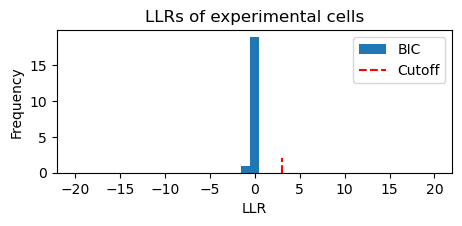

In [ ]:
od.bic_plot

In [ ]:
# --- ROC analysis using BIC differences --- #

# Split BIC differences into two groups: A (first n_cells) and B (next n_cells)
A = BICdiffTOT[:n_cells]
B = BICdiffTOT[n_cells : 2 * n_cells]
print(A.shape, B.shape)

# Define a threshold vector spanning a little below the min to a little above the max.
thresh = np.linspace(BICdiffTOT.min() - 1, BICdiffTOT.max() + 1, 200)
FP1 = np.zeros_like(thresh)
TP1 = np.zeros_like(thresh)
for i, th in enumerate(thresh):
    FP1[i] = np.sum(A > th)
    TP1[i] = np.sum(B > th)

FP1

(10,) (10,)


array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10.,  8.,  5.,  4.,  2.,
        1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0

In [ ]:
# --- ROC analysis using Lomb–Scargle beat detection ---#
d_noise, d_t, d_n = sim_params[0]
print(d_noise, d_t / 60, d_n * 2)

# Define thrvec as the exponential of 200 points linearly spaced between -15 and -0.01
thrvec = np.exp(np.linspace(-15, -0.01, 200))

# Preallocate arrays for FP2 and TP2. Their length is the same as thrvec.
FP2 = np.zeros(len(thrvec))
TP2 = np.zeros(len(thrvec))

# Preallocate beatvec for the number of columns in dataTOT.
# (dataTOT is assumed to have shape (n_samples, 2*CellNum))
beatvec = np.zeros(total_columns)

# Loop over threshold values
for i, thr in enumerate(thrvec):
    # For each signal in dataTOT:
    for j, y in enumerate(y_list):
        # preprocess and compute the Lomb-Scargle periodogram
        y_processed = y  # (y - np.mean(y)) / np.std(y)
        ls = LombScargle(x, y, normalization="standard")

        # Compute power at frequencies, then compute false alarm probability at them
        freq, power = ls.autopower()
        p_vals = ls.false_alarm_probability(power)

        # If any p-value is below the threshold, set the corresponding beatvec element to 1
        beatvec[j] = int(np.any(p_vals < thr))

    # Split detections into two groups, analogous to MATLAB’s A and B.
    A = beatvec[:n_cells]
    B = beatvec[n_cells : 2 * n_cells]
    FP2[i] = np.sum(A)
    TP2[i] = np.sum(B)


0.31622776601683794 25.0 20


/Users/tsd/miniforge3/envs/GP/lib/python3.12/site-packages/astropy/timeseries/periodograms/lombscargle/_statistics.py:251: RuntimeWarning: invalid value encountered in sqrt
  return _gamma(NH) * W * (1 - Z) ** (0.5 * (NK - 1)) * np.sqrt(0.5 * NH * Z)


In [ ]:
FP2

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
        3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  4.,  4.,  4

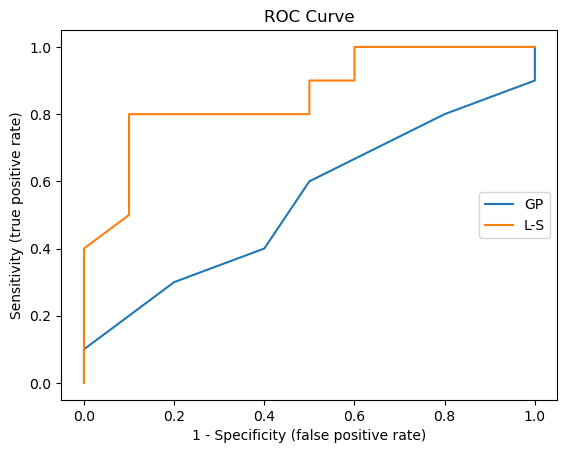

In [ ]:
# --- (Optional) Plot ROC curves ---
plt.figure()
plt.plot(FP1 / n_cells, TP1 / n_cells, label="GP")
plt.plot(FP2 / n_cells, TP2 / n_cells, label="L-S")
plt.xlabel("1 - Specificity (false positive rate)")
plt.ylabel("Sensitivity (true positive rate)")
plt.title("ROC Curve")
plt.legend(loc="center right")
plt.show()


### ROC and plotting

In [5]:
# calculate ROC
fp1_vals, fp2_vals, tp1_vals, tp2_vals = [], [], [], []
for path, (noise, t_final, n_cells) in zip(paths, sim_params):
    fp1, tp1, fp2, tp2 = plots.compute_rocs_from_file(path, noise, n_cells, joblib=True)
    fp1_vals.append(fp1)
    tp1_vals.append(tp1)
    fp2_vals.append(fp2)
    tp2_vals.append(tp2)

Loaded data with 1000 cells, noise set to 0.31622776601683794
Plots: on


Fitting BIC...
Homogeneous traces


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 172 tasks      | elapsed:   31.1s
/Users/tsd/miniforge3/envs/GP/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done 422 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 772 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  3.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 14 concurrent workers.


Homogeneous traces


[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    5.7s
2025-03-11 07:39:06.077839: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.
2025-03-11 07:39:06.229438: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.
2025-03-11 07:39:06.236597: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.
2025-03-11 07:39:08.727273: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.
2025-03-11 07:39:09.702529: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eig

Cell 25 has 1 NaN values in model log-likelihoods
Cell 408 has 1 NaN values in model log-likelihoods
Cell 530 has 1 NaN values in model log-likelihoods
Number of cells counted as oscillatory (BIC method): 62/1000


/Users/tsd/miniforge3/envs/GP/lib/python3.12/site-packages/astropy/timeseries/periodograms/lombscargle/_statistics.py:251: RuntimeWarning: invalid value encountered in sqrt
  return _gamma(NH) * W * (1 - Z) ** (0.5 * (NK - 1)) * np.sqrt(0.5 * NH * Z)
/Users/tsd/miniforge3/envs/GP/lib/python3.12/site-packages/astropy/timeseries/periodograms/lombscargle/_statistics.py:251: RuntimeWarning: invalid value encountered in power
  return _gamma(NH) * W * (1 - Z) ** (0.5 * (NK - 1)) * np.sqrt(0.5 * NH * Z)


Loaded data with 1000 cells, noise set to 0.7071067811865476
Plots: on


Fitting BIC...
Homogeneous traces


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 14 concurrent workers.
/Users/tsd/miniforge3/envs/GP/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 172 tasks      | elapsed:   30.7s
[Parallel(n_jobs=-1)]: Done 422 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 772 tasks      | elapsed:  2.2min


Homogeneous traces


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  2.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 14 concurrent workers.
2025-03-11 07:46:46.325858: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.
2025-03-11 07:46:46.327075: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    4.9s
2025-03-11 07:46:57.817537: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.
2025-03-11 07:47:00.653659: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-trian

Cell 382 has 1 NaN values in model log-likelihoods
Cell 672 has 1 NaN values in model log-likelihoods
Cell 769 has 1 NaN values in model log-likelihoods
Number of cells counted as oscillatory (BIC method): 24/1000


/Users/tsd/miniforge3/envs/GP/lib/python3.12/site-packages/astropy/timeseries/periodograms/lombscargle/_statistics.py:251: RuntimeWarning: invalid value encountered in sqrt
  return _gamma(NH) * W * (1 - Z) ** (0.5 * (NK - 1)) * np.sqrt(0.5 * NH * Z)
/Users/tsd/miniforge3/envs/GP/lib/python3.12/site-packages/astropy/timeseries/periodograms/lombscargle/_statistics.py:251: RuntimeWarning: invalid value encountered in power
  return _gamma(NH) * W * (1 - Z) ** (0.5 * (NK - 1)) * np.sqrt(0.5 * NH * Z)


Loaded data with 1000 cells, noise set to 0.31622776601683794
Plots: on


Fitting BIC...
Homogeneous traces


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 14 concurrent workers.
/Users/tsd/miniforge3/envs/GP/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 172 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done 422 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 772 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  2.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 14 concurrent workers.


Homogeneous traces


2025-03-11 07:54:21.235374: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    5.4s
2025-03-11 07:54:25.147650: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.
2025-03-11 07:54:32.200452: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.
2025-03-11 07:54:32.201454: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.
2025-03-11 07:54:33.145082: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eig

Cell 305 has 1 NaN values in model log-likelihoods
Cell 714 has 1 NaN values in model log-likelihoods
Number of cells counted as oscillatory (BIC method): 68/1000


/Users/tsd/miniforge3/envs/GP/lib/python3.12/site-packages/astropy/timeseries/periodograms/lombscargle/_statistics.py:251: RuntimeWarning: invalid value encountered in sqrt
  return _gamma(NH) * W * (1 - Z) ** (0.5 * (NK - 1)) * np.sqrt(0.5 * NH * Z)
/Users/tsd/miniforge3/envs/GP/lib/python3.12/site-packages/astropy/timeseries/periodograms/lombscargle/_statistics.py:251: RuntimeWarning: invalid value encountered in power
  return _gamma(NH) * W * (1 - Z) ** (0.5 * (NK - 1)) * np.sqrt(0.5 * NH * Z)


=== Debug Info: Checking shapes and partial data ===
dataNORMED1 shape: (51, 1000)
dataNORMED2 shape: (51, 1000)
dataNORMED3 shape: (21, 1000)
FP11[:5]: [500. 500. 500. 500. 500.] TP11[:5]: [500. 500. 500. 500. 500.]
FP21[:5]: [0. 0. 0. 0. 0.] TP21[:5]: [30. 30. 30. 31. 31.]
FP12[:5]: [500. 500. 500. 500. 500.] TP12[:5]: [500. 500. 500. 500. 500.]
FP22[:5]: [0. 0. 0. 0. 0.] TP22[:5]: [11. 11. 11. 11. 11.]
FP13[:5]: [500. 500. 500. 500. 500.] TP13[:5]: [500. 500. 500. 500. 500.]
FP23[:5]: [0. 0. 0. 0. 0.] TP23[:5]: [8. 8. 8. 8. 9.]


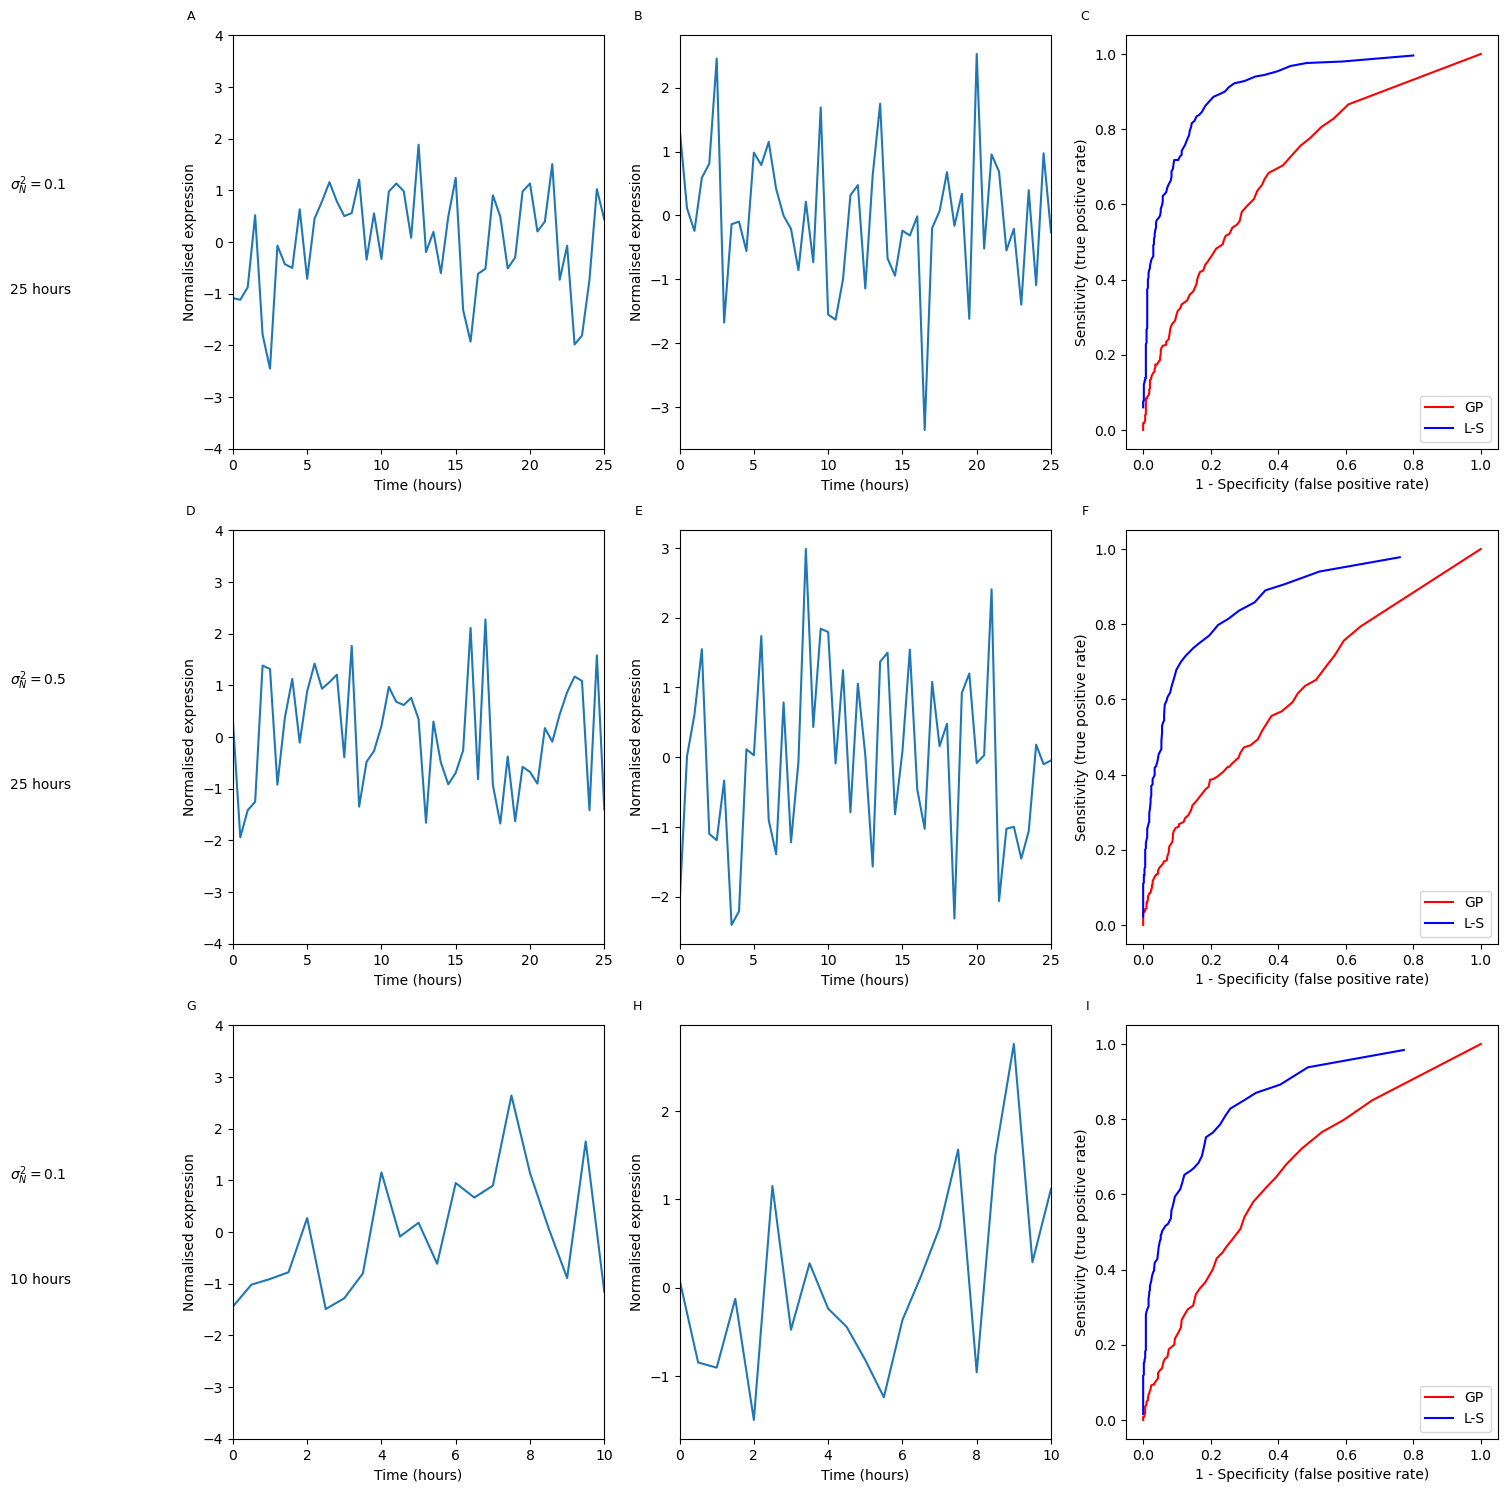

In [6]:
import pandas as pd

# plot ROC
x_arr = []
dataNormed_arr = []

for path in paths:
    df = pd.read_csv(path)

    x = df["Time"].values
    dataNormed = df.drop(columns=["Time"]).values

    x_arr.append(x)
    dataNormed_arr.append(dataNormed)

plots.plot_rocs_and_timeseries(
    x_arr[0],
    dataNormed_arr[0],
    fp1_vals[0],
    tp1_vals[0],
    fp2_vals[0],
    tp2_vals[0],
    x_arr[1],
    dataNormed_arr[1],
    fp1_vals[1],
    tp1_vals[1],
    fp2_vals[1],
    tp2_vals[1],
    x_arr[2],
    dataNormed_arr[2],
    fp1_vals[2],
    tp1_vals[2],
    fp2_vals[2],
    tp2_vals[2],
    n_cells,
)